### Import Libraries

In [7]:
import re
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from haversine import haversine

In [ ]:
df = pd.read_csv("Dataset/airbnb_with_landmark_features.csv")

#### Light Cleaning of Data

In [10]:
df['price'] = np.exp(df["log_price"])

### Rationale for Investigating Metro Proximity
Our exploratory data analysis (EDA) on geospatial features highlighted patterns indicating that proximity to metro stations may significantly influence Airbnb pricing. Metro access, being a critical aspect of urban convenience and connectivity, is hypothesized to enhance the desirability of accommodations. Specifically, we hypothesize that the nearer an Airbnb is to a metro station, the more convenient its location is perceived to be, resulting in higher pricing.

The metro data for each of the six cities was collected online, including the latitude and longitude of each station. By engineering features such as the distance to the nearest metro station and density of nearby stations, we aim to explore their relationship with Airbnb pricing.

#### Function to load data from multiple .csv in a folder

In [ ]:
def load_data_from_folder(folder_path):
    """
    Load and concatenate data from CSV files in a specified folder.

    Args:
        folder_path (str): Path to the folder containing the CSV files.

    Returns:
        pd.DataFrame: A concatenated DataFrame with an additional 'city' column.
    """
    # List to store data from each CSV
    data = []

    # Loop through all files in the specified folder
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".csv"):  # Check if the file is a CSV
            file_path = os.path.join(folder_path, file_name)  # Full path to the file
            city_df = pd.read_csv(file_path)  # Read the CSV into a DataFrame
            city_name = file_name.replace(".csv", "")  # Extract the city name from the file name
            city_df["city"] = city_name  # Add a column for the city name
            data.append(city_df)  # Append the DataFrame to the list

    # Concatenate all the city DataFrames into a single DataFrame
    concatenated_df = pd.concat(data, ignore_index=True)

    return concatenated_df

### Load Metro Data and Clean

In [ ]:
metro_folder_path = "Dataset/metro"
metro_df = load_data_from_folder(metro_folder_path)
metro_df = metro_df[["X", "Y", "Name", "city"]]
metro_df

,X,Y,Name,city
0,-87.756698,41.851781,54th/Cermak,Chicago
1,-87.747227,42.026252,Oakton-Skokie,Chicago
2,-87.724333,41.853865,Pulaski,Chicago
3,-87.708547,41.929736,Logan Square,Chicago
4,-87.729183,41.952948,Irving Park,Chicago
...,...,...,...,...
2635,-77.415297,38.960766,NaN,DC
2636,-77.448150,38.955792,NaN,DC
2637,-77.460687,38.992048,NaN,DC
2638,-77.491539,39.005291,NaN,DC


### Feature Engineering with Metro Data

#### Haversine Function

In [57]:
# Function to calculate Haversine distance
def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the Haversine distance between two points on the Earth.

    Args:
        lat1, lon1: Latitude and longitude of point 1 (in degrees).
        lat2, lon2: Latitude and longitude of point 2 (in degrees).

    Returns:
        Distance in meters.
    """
    R = 6371000  # Radius of Earth in meters
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

#### Create Features
We create features such as:
-  Number of Metro Stations within 500m
-  Number of Metro Stations within 1000m
-  Number of Metro Stations within 5000m
-  Shortest distance to Metro Stations within City

In [59]:
# Normalize city names
metro_df["city"] = metro_df["city"].str.strip().str.lower()

# Initialize new columns
df["metro_within_500m"] = 0
df["metro_within_1000m"] = 0
df["metro_within_5000m"] = 0
df["shortest_distance_to_metro"] = np.nan

# Loop through each row in the Airbnb dataframe
for index, airbnb in df.iterrows():
    # Get Airbnb location and city
    airbnb_lat = airbnb["latitude"]
    airbnb_lon = airbnb["longitude"]
    airbnb_city = airbnb["city"]

    # Filter metro stations in the same city
    city_metro = metro_df[metro_df["city"] == airbnb_city]

    if city_metro.empty:
        continue

    # Calculate distances between the Airbnb property and all metro stations in the city
    distances = city_metro.apply(
        lambda row: haversine(airbnb_lat, airbnb_lon, row["Y"], row["X"]),
        axis=1
    )

    # Count metro stations within distance thresholds
    df.at[index, "metro_within_500m"] = sum(distances <= 500)
    df.at[index, "metro_within_1000m"] = sum(distances <= 1000)
    df.at[index, "metro_within_5000m"] = sum(distances <= 5000)

    # Calculate the shortest distance to any metro station
    if not distances.empty:
        df.at[index, "shortest_distance_to_metro"] = distances.min()

### Let's see how these engineered features perform in correlation

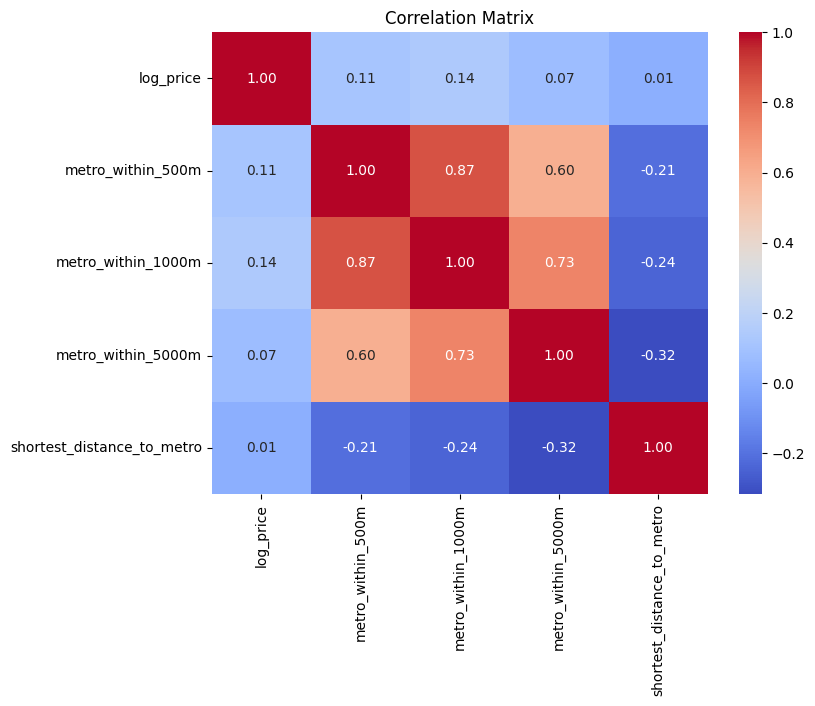

In [62]:
# Select columns of interest for correlation
columns_of_interest = ["log_price", "metro_within_500m", "metro_within_1000m", "metro_within_5000m", "shortest_distance_to_metro"]
# Ensure numeric columns only
corr_df = df[columns_of_interest].corr()
# Plot heatmap for correlations
plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

### Summary of Metro Feature Correlations

1. **Weak Positive Correlations with `log_price`**:
   - `metro_within_500m` (0.11) and `metro_within_1000m` (0.14) show weak positive correlations with `log_price`, suggesting that proximity to metro stations may slightly influence Airbnb prices.
   - `metro_within_5000m` has an even weaker correlation (0.07), indicating that stations further away are less relevant to pricing.

2. **Negative Correlation of `shortest_distance_to_metro`**:
   - `shortest_distance_to_metro` has a weak negative correlation (0.01) with `log_price`, indicating that properties closer to metro stations may have slightly higher prices, though the effect is minimal.

3. **Inter-Feature Correlations**:
   - Features such as `metro_within_500m`, `metro_within_1000m`, and `metro_within_5000m` are strongly correlated with each other (e.g., `0.87` between `metro_within_500m` and `metro_within_1000m`), reflecting overlapping areas covered by the thresholds.

### Conclusion

While the correlation analysis shows weak relationships between metro proximity and Airbnb pricing, proximity to metro stations may still play a role when combined with other features. Features like `metro_within_1000m` and `shortest_distance_to_metro` might provide marginal insights for predictive modeling but should not be expected to act as strong standalone predictors.

### Save New Data with engineered features

In [ ]:
# Define the path where the new dataset will be saved
output_file_path = "Dataset/airbnb_with_landmark_metro_features.csv"

# Save the DataFrame as a CSV file
df.to_csv(output_file_path, index=False)